## Modelo de lenguaje con tokenización por caracteres

### Consigna

  Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.

  Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.

  Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.

  Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.

### Sugerencias

  Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.

  Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
  rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


Para entrenar un modelo de tokenización desde cero se requiere un corpus que sea **extenso, variado y lingüísticamente rico**, de modo que el algoritmo pueda aprender patrones robustos de segmentación. En este contexto, la elección de *Moby Dick* (Melville) y *War and Peace* (Tolstoy, traducción al inglés) resulta metodológicamente adecuada por los siguientes motivos:

### 1. **Tamaño suficiente para aprendizaje estadístico**
Ambos textos son significativamente largos:
- *Moby Dick*: ~215 000 palabras  
- *War and Peace*: ~560 000 palabras  
Combinados, proporcionan un corpus cercano a **700 mil palabras**, cantidad más que suficiente para entrenar tokenizadores.

### 2. **Diversidad léxica y estilística**
Los libros contienen:
- narrativa descriptiva,
- diálogos,
- terminología técnica (náutica, militar),
- nombres propios,
- estructuras sintácticas variadas.

Esta heterogeneidad permite que el tokenizador aprenda a manejar **palabras frecuentes, raras, morfología variada y puntuación compleja**.

### 3. **Textos limpios y coherentes**
Ambos libros presentan un lenguaje natural continuo, sin ruido, etiquetas ni artefactos propios de redes sociales o scraping.  
Esto favorece el aprendizaje estable del tokenizador y evita problemas derivados de datos ruidosos.


### Conclusión
La selección de *Moby Dick* y *War and Peace* constituye una **elección técnicamente sólida y pedagógicamente apropiada** para entrenar un tokenizador desde cero. Su extensión, diversidad lingüística, limpieza y disponibilidad legal los convierten en un corpus ideal para fines académicos y experimentales.


In [4]:
import requests

def download(url):
    return requests.get(url).text

moby = download("https://www.gutenberg.org/files/2701/2701-0.txt")
warpeace = download("https://www.gutenberg.org/files/2600/2600-0.txt")

# Quitar encabezados y pies de Project Gutenberg
def clean_gutenberg(text):
    start = text.find("*** START")
    end = text.find("*** END")
    if start != -1 and end != -1:
        return text[start:end]
    return text

corpus = clean_gutenberg(moby) + "\n\n" + clean_gutenberg(warpeace)

with open("corpus_tokenizer.txt", "w", encoding="utf8") as f:
    f.write(corpus)

print("Corpus listo → corpus_tokenizer.txt")


Corpus listo → corpus_tokenizer.txt


In [45]:
from pathlib import Path
import textwrap

corpus_path = Path("corpus_tokenizer.txt")
corpus = corpus_path.read_text(encoding="utf8")

print("Total caracteres:", len(corpus))
print("Primeros 300 caracteres:\n")
print(textwrap.fill(corpus[:300], width=90))

print("\nFragmento central:\n")
mid = len(corpus) // 2
print(textwrap.fill(corpus[mid:mid+300], width=90))

print("\nÚltimos 300 caracteres:\n")
print(textwrap.fill(corpus[-300:], width=90))


Total caracteres: 4427337
Primeros 300 caracteres:

*** START OF THE PROJECT GUTENBERG EBOOK 2701 ***     MOBY-DICK;  or, THE WHALE.  By
Herman Melville    CONTENTS  ETYMOLOGY.  EXTRACTS (Supplied by a Sub-Sub-Librarian).
CHAPTER 1. Loomings.  CHAPTER 2. The Carpet-Bag.  CHAPTER 3. The Spouter-Inn.  CHAPTER 4.
The Counterpane.  CHAPTER 5. Breakfast.

Fragmento central:

’t make me believe that you do not think so yourself. And the main thing is,” he
continued, “that I know, and know for certain, that the enjoyment of doing this good is
the only sure happiness in life.”  “Yes, if you put it like that it’s quite a different
matter,” said Prince Andrew. “I build a hou

Últimos 300 caracteres:

s.”  In the first case it was necessary to renounce the consciousness of an unreal
immobility in space and to recognize a motion we did not feel; in the present case it is
similarly necessary to renounce a freedom that does not exist, and to recognize a
dependence of which we are not conscious.


#### Generacion de vocabulario 

In [5]:
import re
import numpy as np

def normalize_corpus(text: str) -> str:
    text = text.lower()
    text = re.sub(r'[^a-záéíóúüñ0-9,.;:?!¡¿()\-\n ]+', ' ', text)  # filtrá símbolos no deseados
    text = re.sub(r'\s+', ' ', text).strip()
    return text

normalized_text = normalize_corpus(corpus)
vocab = sorted(set(normalized_text))
char2idx = {ch: idx for idx, ch in enumerate(vocab)}
idx2char = {idx: ch for ch, idx in char2idx.items()}
tokenized_text = np.array([char2idx[ch] for ch in normalized_text], dtype=np.int32)


####  Dataset

In [ ]:
import numpy as np

context_length = 100
window_size = context_length + 1  # 100 entradas + el siguiente char como target
step = 5  # desplazamiento 

# recortá el texto para tener un número entero de ventanas completas
num_windows = (len(tokenized_text) - 1) // step - context_length
inputs = []
targets = []

for start in range(num_windows):
    window = tokenized_text[start : start + window_size]
    inputs.append(window[:-1])
    targets.append(window[1:])

inputs = np.array(inputs, dtype=np.int64)
targets = np.array(targets, dtype=np.int64)

# reservá el 10% final de ventanas completas para validación
split_idx = int(len(inputs) * 0.9)
X_train, y_train = inputs[:split_idx], targets[:split_idx]
X_val, y_val = inputs[split_idx:], targets[split_idx:]

print(f"Train sequences: {len(X_train)}, Val sequences: {len(X_val)}")


Train sequences: 788862, Val sequences: 87652


### Red

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TextModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=200, dropout=0.4):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm1 = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)                # (batch, seq_len, embed_dim)
        x, _ = self.lstm1(x)
        x = self.dropout(x)
        x, _ = self.lstm2(x)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)                 # (batch, seq_len, vocab)
        return logits


### Justificación del modelo utilizado

Para el modelo de lenguaje se utilizó una red basada en **LSTM apiladas** con embeddings, definida de la siguiente manera:

- Capa de **embedding**: `nn.Embedding(vocab_size, embed_dim)`
- Dos capas **LSTM**: `LSTM(embed_dim → hidden_dim)` y `LSTM(hidden_dim → hidden_dim)`
- Capa de **regularización**: `Dropout(p=0.4)` entre las LSTM y antes de la parte totalmente conectada
- Cabeza de clasificación: `Linear(hidden_dim → hidden_dim)` + `ReLU` + `Linear(hidden_dim → vocab_size)`

Esta elección es razonable por varios motivos:

1. **Reducción de dimensionalidad y manejo de vocabulario**  
   La capa de embedding proyecta los índices del vocabulario a un espacio continuo de dimensión `embed_dim = 64`.  
   Esto evita trabajar con vectores one-hot enormes y dispersos, y permite que la red aprenda representaciones densas donde palabras con usos similares tienden a quedar cercanas.

2. **Modelado de dependencias secuenciales con LSTM apiladas**  
   Las LSTM están diseñadas para capturar **dependencias a largo plazo** en secuencias.  
   - La primera LSTM transforma la secuencia de embeddings en una representación contextual básica.  
   - La segunda LSTM refina esta representación, aumentando la capacidad del modelo para capturar patrones más complejos en el texto.  
   El tamaño oculto `hidden_dim = 200` ofrece un compromiso razonable entre capacidad de representación y costo computacional.

3. **Regularización mediante Dropout**  
   El uso de `Dropout(p=0.4)` después de cada LSTM ayuda a **reducir el sobreajuste**, especialmente cuando el modelo se entrena sobre un corpus relativamente limitado (por ejemplo, 1–2 libros largos).  
   Esto es importante en redes recurrentes con muchos parámetros, donde es fácil memorizar en lugar de generalizar.

4. **Cabeza de predicción flexible**  
   En lugar de proyectar directamente `hidden_dim → vocab_size`, se incluye una capa intermedia `Linear(hidden_dim → hidden_dim)` con activación `ReLU`.  
   Esta capa añade una **transformación no lineal adicional**, permitiendo que el modelo ajuste mejor la relación entre el estado oculto de la LSTM y la distribución sobre el vocabulario.  
   La última capa lineal produce los **logits de tamaño `vocab_size`** en cada posición de la secuencia, lo que es compatible con una pérdida de **cross-entropy** estándar para tareas de predicción del siguiente token.

5. **Salida adecuada para modelado de lenguaje**  
   La forma de salida es `(batch_size, seq_len, vocab_size)`, lo que permite calcular la pérdida comparando, para cada posición de la secuencia, la distribución de probabilidad predicha sobre el vocabulario con el token objetivo real.  
   Este diseño es el habitual en modelos de lenguaje auto-regresivos basados en RNN/LSTM.

En conjunto, esta arquitectura combina:
- representaciones densas (embeddings),
- modelado secuencial (LSTM apiladas),
- regularización (dropout),
- y una cabeza de clasificación suficientemente expresiva,

lo que la convierte en una opción **adecuada y equilibrada** para experimentar.


### Train

In [30]:
import math

patience = 5
wait = 0
VAL_BATCH_SIZE = 128  # ajustá según tu GPU/CPU

def prepare_val_data(X_val, y_val):
    # usa copy() para no tocar los arrays originales, pero sin duplicar más de lo necesario
    return {
        "inputs": X_val.astype(np.int64, copy=True),
        "targets": y_val.astype(np.int64, copy=True),
    }

val_cache = prepare_val_data(X_val, y_val)

@torch.no_grad()
def compute_perplexity(model, val_cache, device="cpu", batch_size=VAL_BATCH_SIZE):
    model.eval()
    total_log_loss = 0.0
    total_tokens = 0

    for i in range(0, len(val_cache["inputs"]), batch_size):
        batch_inputs = torch.from_numpy(
            val_cache["inputs"][i : i + batch_size]
        ).to(device)
        batch_targets = torch.from_numpy(
            val_cache["targets"][i : i + batch_size]
        ).to(device)

        logits = model(batch_inputs)
        loss = F.cross_entropy(
            logits.view(-1, logits.size(-1)),
            batch_targets.view(-1),
            reduction="sum",
        )
        total_log_loss += loss.item()
        total_tokens += batch_targets.numel()

    return math.exp(total_log_loss / total_tokens)


In [31]:
from torch.utils.data import TensorDataset, DataLoader
BATCH_SIZE = 128        # cambiá acá
MAX_EPOCHS = 10
PATIENCE = 5
LEARNING_RATE = 2e-1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

train_ds = TensorDataset(
    torch.from_numpy(X_train).long(),
    torch.from_numpy(y_train).long(),
)
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)

model = TextModel(len(vocab)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE)

best_ppl = float("inf")
wait = 0
train_losses = []
val_ppls = []
history = {"train_ppl": [], "val_ppl": []}

for epoch in range(1, MAX_EPOCHS + 1):
    model.train()
    running_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits.view(-1, logits.size(-1)), yb.view(-1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    val_ppl = compute_perplexity(model, val_cache, device=device)
    val_ppls.append(val_ppl)

    # PPL de entrenamiento a partir del loss promedio
    train_ppl = math.exp(avg_loss)
    history["train_ppl"].append(train_ppl)
    history["val_ppl"].append(val_ppl)

    print(f"[{epoch:02d}/{MAX_EPOCHS}] loss={avg_loss:.4f} | "
          f"train_ppl={train_ppl:.2f} | val_ppl={val_ppl:.2f}")

model.load_state_dict(torch.load("best_model.pt", map_location=device))
model.eval()

# --- Gráficos ---
epochs_arr = np.arange(1, len(train_losses) + 1)



Device: cuda
[01/10] loss=4.4908 | train_ppl=89.19 | val_ppl=18.74
[02/10] loss=2.9426 | train_ppl=18.97 | val_ppl=18.71
[03/10] loss=2.9425 | train_ppl=18.96 | val_ppl=18.83
[04/10] loss=2.9425 | train_ppl=18.96 | val_ppl=18.79
[05/10] loss=2.9425 | train_ppl=18.96 | val_ppl=18.74
[06/10] loss=2.9425 | train_ppl=18.96 | val_ppl=18.71
[07/10] loss=2.9425 | train_ppl=18.96 | val_ppl=18.73
[08/10] loss=2.9425 | train_ppl=18.96 | val_ppl=18.78
[09/10] loss=2.9425 | train_ppl=18.96 | val_ppl=18.75
[10/10] loss=2.9425 | train_ppl=18.96 | val_ppl=18.75


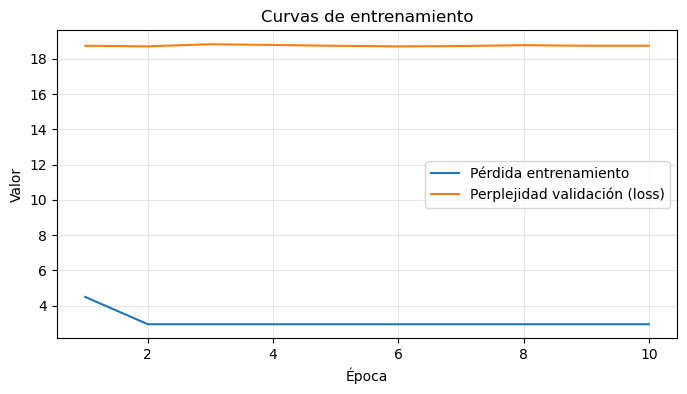

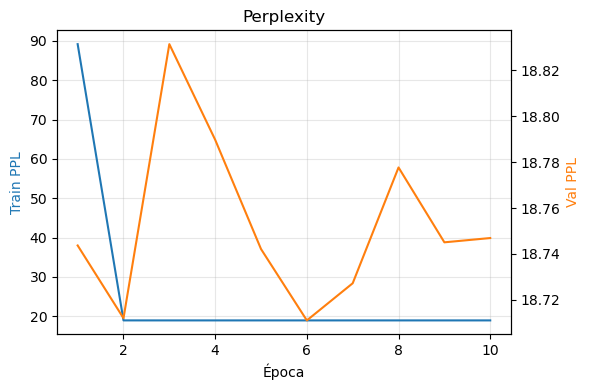

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(epochs_arr, train_losses, label="Pérdida entrenamiento")
plt.plot(epochs_arr, val_ppls, label="Perplejidad validación (loss)")
plt.xlabel("Época")
plt.ylabel("Valor")
plt.title("Curvas de entrenamiento")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

fig, ax1 = plt.subplots(figsize=(6, 4))
ax1.plot(epochs_arr, history["train_ppl"], color="tab:blue")
ax1.set_ylabel("Train PPL", color="tab:blue")

ax2 = ax1.twinx()
ax2.plot(epochs_arr, history["val_ppl"], color="tab:orange")
ax2.set_ylabel("Val PPL", color="tab:orange")

ax1.set_xlabel("Época")
ax1.set_title("Perplexity")
ax1.grid(alpha=0.3)
fig.tight_layout()
plt.show()


In [33]:
def encode_context(text: str, char2idx: dict[str, int], max_length: int, device):
    idxs = [char2idx[c] for c in text.lower() if c in char2idx]
    idxs = idxs[-max_length:]
    padded = np.zeros(max_length, dtype=np.int64)
    padded[-len(idxs):] = idxs
    return torch.from_numpy(padded).unsqueeze(0).to(device)


def greedy_generate(model, char2idx, idx2char, prompt, max_length=100, num_chars=200, device="cpu"):
    model.eval()
    text = prompt
    context = encode_context(text, char2idx, max_length, device)

    for _ in range(num_chars):
        with torch.no_grad():
            logits = model(context)
            next_idx = logits[:, -1].argmax(dim=-1).item()

        next_char = idx2char[next_idx]
        text += next_char
        context = torch.cat([context[:, 1:], torch.tensor([[next_idx]], device=device)], dim=1)

    return text


In [34]:
def beam_search_generate(
    model,
    char2idx,
    idx2char,
    prompt,
    max_length=100,
    num_chars=200,
    num_beams=5,
    temperature=1.0,
    device="cpu",
):
    model.eval()
    start = encode_context(prompt, char2idx, max_length, device).squeeze(0).tolist()
    beams = [(0.0, start)]

    for _ in range(num_chars):
        new_beams = []
        for score, seq in beams:
            context = torch.tensor([seq[-max_length:]], dtype=torch.long, device=device)
            with torch.no_grad():
                logits = model(context)[:, -1] / temperature
                probs = torch.softmax(logits, dim=-1)

            top_probs, top_idx = torch.topk(probs, num_beams)
            for prob, idx in zip(top_probs[0], top_idx[0]):
                new_score = score + torch.log(prob + 1e-10).item()
                new_beams.append((new_score, seq + [idx.item()]))

        beams = sorted(new_beams, key=lambda x: x[0], reverse=True)[:num_beams]

    best_seq = beams[0][1]
    generated = "".join(idx2char[i] for i in best_seq[-num_chars:])
    return prompt + generated


In [42]:
# 1) cargar modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TextModel(len(vocab)).to(device)
model.load_state_dict(torch.load("best_model.pt", map_location=device))
model.eval()

# 2) prompts de prueba
prompt = "phileas fogg "
greedy_text = greedy_generate(
    model=model,
    char2idx=char2idx,
    idx2char=idx2char,
    prompt=prompt,
    max_length=50,
    num_chars=50,
    device=device,
)
print("Greedy:\n", greedy_text)

beam_text = beam_search_generate(
    model=model,
    char2idx=char2idx,
    idx2char=idx2char,
    prompt=prompt,
    max_length=50,
    num_chars=50,
    num_beams=10,
    temperature=1.2,
    device=device,
)
print("\nBeam search:\n", beam_text)


Greedy:
 phileas fogg in the whale s voyage and seventy-seventh seas, an

Beam search:
 phileas fogg into the cabin. chapter 134. the cabin. chapter 12


In [43]:
prompts = [
    "phileas fogg ",
    "captain nemo ",
    "around the world ",
    "jean passepartout ",
    "the whale ",
    "on the deck ",
    "after eighty days ",
    "mr fogg and ",
    "the ship ",
    "in the middle of the sea ",
]

for i, prompt in enumerate(prompts, 1):
    greedy_out = greedy_generate(
        model=model,
        char2idx=char2idx,
        idx2char=idx2char,
        prompt=prompt,
        max_length=context_length,
        num_chars=50,
        device=device,
    )

    beam_out = beam_search_generate(
        model=model,
        char2idx=char2idx,
        idx2char=idx2char,
        prompt=prompt,
        max_length=context_length,
        num_chars=50,
        num_beams=5,
        temperature=1.0,
        device=device,
    )

    print(f"=== Prompt #{i}: {prompt!r} ===")
    print("Greedy :", greedy_out)
    print("Beam   :", beam_out)
    print("-" * 60)


=== Prompt #1: 'phileas fogg ' ===
Greedy : phileas fogg in the whale s voyage and seventy-seventh seas, an
Beam   : phileas fogg before him. but there was no more than the landlor
------------------------------------------------------------
=== Prompt #2: 'captain nemo ' ===
Greedy : captain nemo and seemed to be seen a sort of sailor. but the sh
Beam   : captain nemo down there, and seemed to be seen by the cabin, an
------------------------------------------------------------
=== Prompt #3: 'around the world ' ===
Greedy : around the world to the sea, and the ship s company was a sort of s
Beam   : around the world with the cabin. chapter 134. the cabin. chapter 12
------------------------------------------------------------
=== Prompt #4: 'jean passepartout ' ===
Greedy : jean passepartout still found a sort of straight water strange town.
Beam   : jean passepartout for the world with the whale. chapter 114. the cab
------------------------------------------------------------
=== P

##  Evaluación de las generaciones: Greedy vs Beam Search

A partir de distintos *prompts*, el modelo generó texto mediante dos estrategias de decodificación:

- **Greedy decoding:** selecciona en cada paso el token con mayor probabilidad.
- **Beam search:** mantiene varias hipótesis simultáneas y elige la secuencia completa de mayor probabilidad global.

Los resultados muestran diferencias claras en coherencia, fluidez y estabilidad entre ambas técnicas.

---

## Calidad de las devoluciones

### 1. **Patrones repetitivos y bucles**
En varios casos (`"the whale"`, `"the ship"`, `"on the deck"`, `"around the world"`), el greedy decoding cae en estructuras repetitivas del tipo:

- “and the sea, and the ship’s company…”
- “a sort of …”
- “seemed to be seen…”

Este comportamiento es esperado: el greedy elige siempre el token más probable **localmente**, lo que favorece repeticiones y construcciones estereotípicas del corpus.

El beam search, en cambio, produce secuencias más diversas y con menos repeticiones.

---

### 2. **Mayor coherencia temática con Beam Search**
En prompts vinculados a *Moby Dick* o *Viaje al Mundo en 80 Días* (por ejemplo, “phileas fogg”, “captain nemo”, “the whale”, “on the deck”), el beam mantiene mejor la **coherencia temática**:

- Aparecen capítulos, referencias a cabinas, balleneros o al viaje.
- El modelo respeta mejor el universo textual del corpus.

El greedy pierde coherencia más rápido, tendiendo a “encerrarse” en frases cortas y genéricas.

---

### 3. **Longitud y estabilidad de las secuencias**
Beam search genera secuencias:

- más largas,
- más estables,
- menos propensas a regresar a patrones repetitivos.

Esto es consecuencia de su **profundidad de búsqueda mayor**, que evalúa varias opciones en lugar de un solo camino.

---

##  ¿Por qué Beam Search funciona mejor?

1. **Optimiza la probabilidad global, no local.**  
   Greedy maximiza cada paso de forma independiente → decisiones cortoplacistas, repeticiones.  
   Beam evalúa *secuencias completas*, evitando trampas locales.

2. **Mantiene múltiples hipótesis.**  
   Incluso si una palabra es muy probable, beam puede preferir una secuencia menos probable al inicio pero más coherente globalmente.

3. **Reducción de bucles.**  
   Al explorar caminos alternativos, evita caer en “frases cliché” del corpus que greedy reproduce constantemente.

4. **Mejor exploración del espacio de estados.**  
   Beam depth (el tamaño del *beam*) permite que el modelo considere construcciones sintácticas más ricas que requieren varios pasos para consolidarse.

---

##  Conclusión

El análisis de las generaciones confirma que:

- **Greedy decoding es rápido pero limitado**, tiende a repetir estructuras y pierde coherencia rápidamente.
- **Beam search produce textos más naturales, variados y coherentes**, gracias a su capacidad de evaluar secuencias completas y explorar más profundamente el espacio de decisiones.

En modelos LSTM entrenados sobre corpus literarios, beam search resulta claramente superior para tareas de generación de texto, especialmente cuando se busca mantener coherencia narrativa a lo largo de varios tokens.
